Resultados para Evap_Dalton_Calc:
                    MSE        R2
Random Forest  0.519190  0.726224
KNN            0.400126  0.789008
Decision Tree  1.286385  0.321673
SVM            0.382348  0.798383
Resultados para Evap_Penman_Calc:
                    MSE        R2
Random Forest  0.228282  0.723655
KNN            0.174295  0.789008
Decision Tree  0.525530  0.363823
SVM            0.163018  0.802659
Resultados para Evap_Empirical_Calc:
                    MSE        R2
Random Forest  0.001608  0.934978
KNN            0.001755  0.929047
Decision Tree  0.002252  0.908945
SVM            0.002164  0.912517


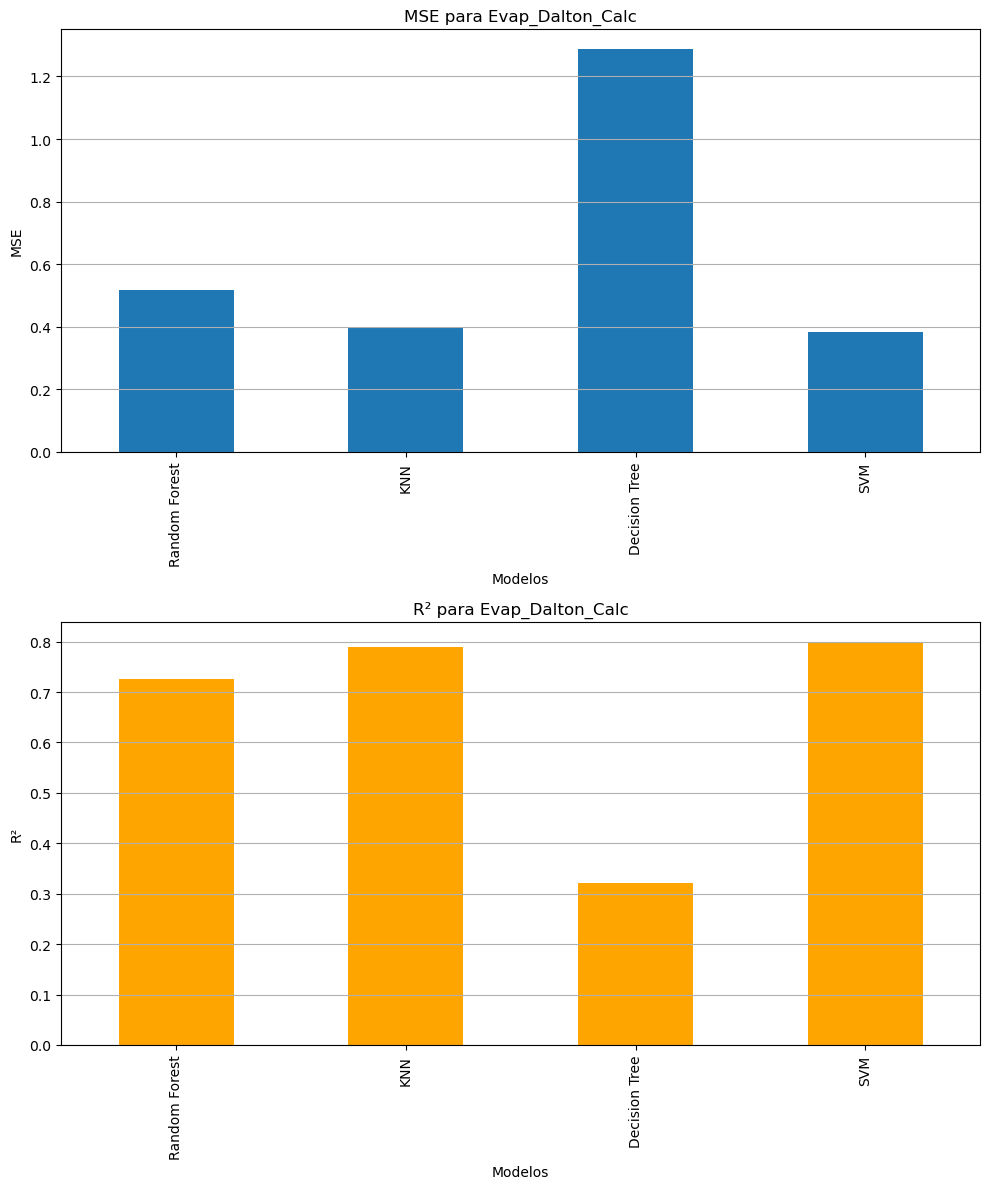

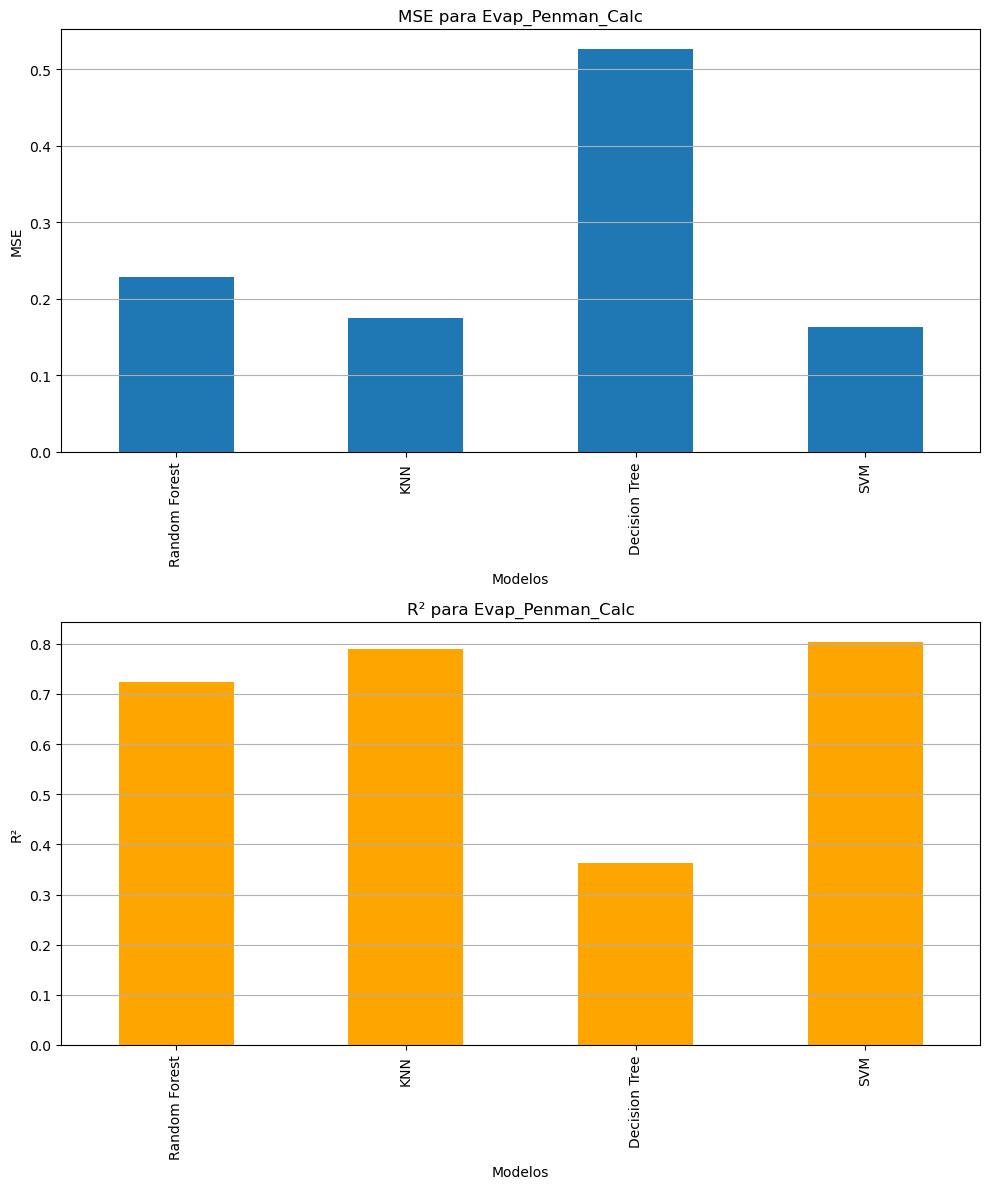

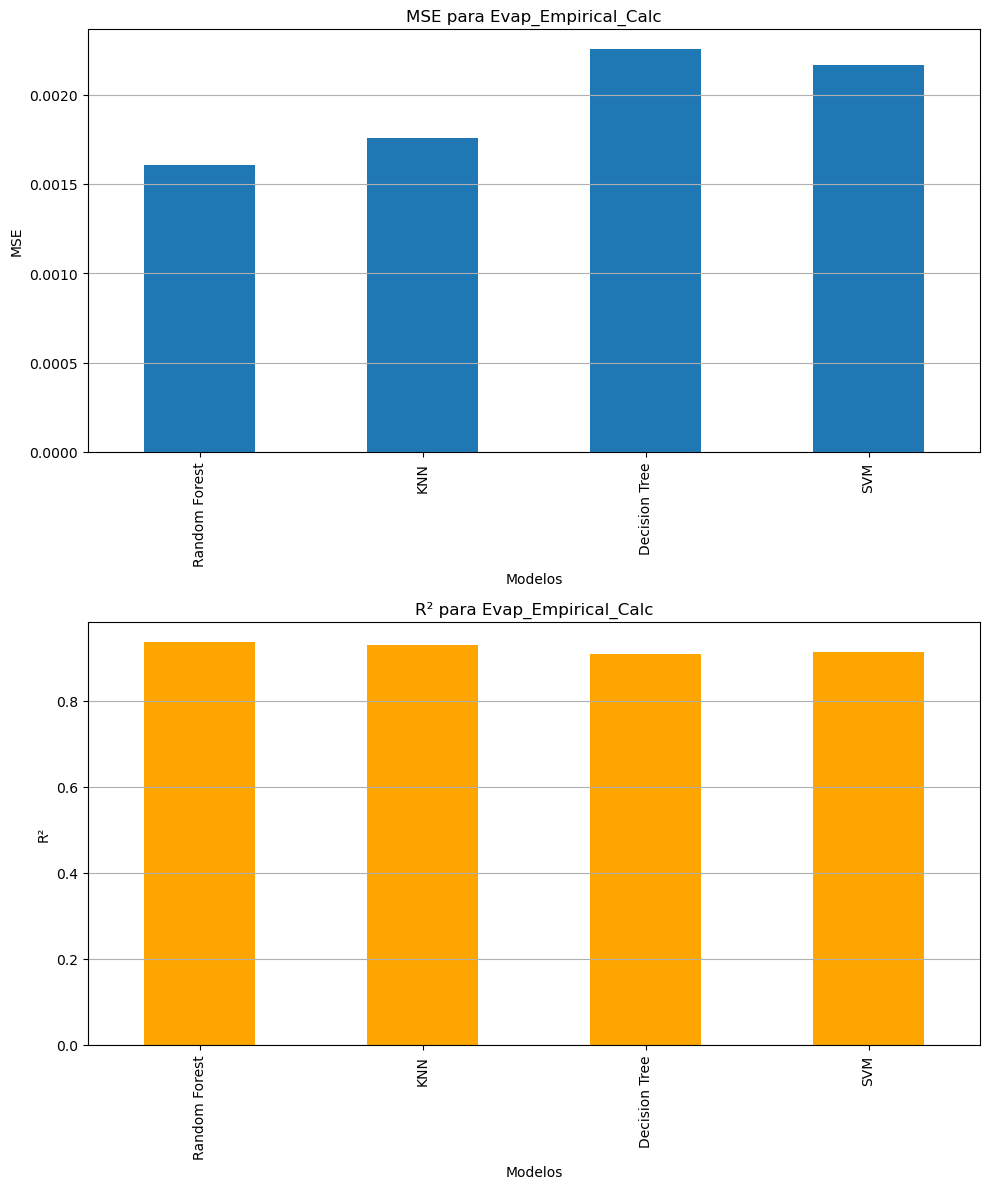

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('03A_Dataset.csv', low_memory=False)

# Definir las variables y el objetivo
variables = ['Promedio semana Vv', 'Promedio Semana Temp']
targets = ['Evap_Dalton_Calc', 'Evap_Penman_Calc', 'Evap_Empirical_Calc']

resultados = {}

for target in targets:
    # Filtrar datos no nulos
    model_data = data[variables + [target]].dropna()

    # Separar en características (X) y objetivo (y)
    X = model_data[variables]
    y = model_data[target]

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear modelos predictivos
    modelos = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "KNN": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "SVM": SVR(kernel='rbf')
    }

    resultados_target = {}

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        resultados_target[nombre] = {"MSE": mse, "R2": r2}

    resultados[target] = pd.DataFrame(resultados_target).T

# Mostrar resultados
for target, res in resultados.items():
    print(f"Resultados para {target}:")
    print(res)

# Graficar resultados de evaporación
for target, res in resultados.items():
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    res['MSE'].plot(kind='bar', ax=ax[0], title=f'MSE para {target}', ylabel='MSE', xlabel='Modelos')
    ax[0].grid(axis='y')
    res['R2'].plot(kind='bar', ax=ax[1], title=f'R² para {target}', ylabel='R²', xlabel='Modelos', color='orange')
    ax[1].grid(axis='y')
    plt.tight_layout()
    plt.show()

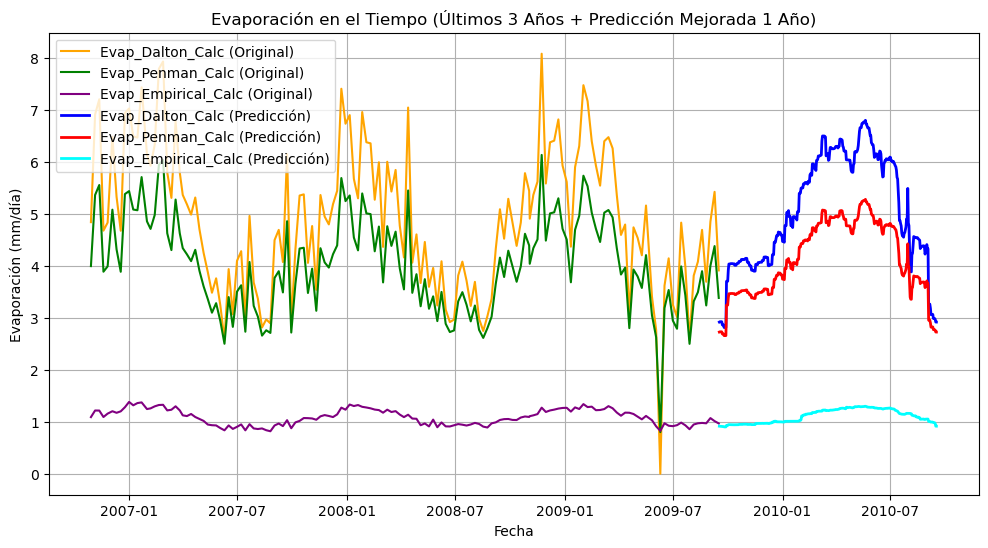

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('03A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Actualizado el formato

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset original con evaporaciones y fechas
data_subset = data[['FECHA', 'Evap_Dalton_Calc', 'Evap_Penman_Calc', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporaciones
predictions_rf_improved = {}
for column in ['Evap_Dalton_Calc', 'Evap_Penman_Calc', 'Evap_Empirical_Calc']:
    try:
        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        X = data_subset[['DayOfYear', 'DaysSinceStart']]
        y = data_subset[column]
        model_rf.fit(X, y)
        
        # Generar predicciones para 1 año
        future_days = pd.DataFrame({
            'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
            'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
        })
        predictions_rf_improved[column] = model_rf.predict(future_days)
    except Exception as e:
        print(f"Error ajustando el modelo RandomForest para {column}: {e}")

# Crear un DataFrame con las predicciones
try:
    future_dates_rf_improved = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf_improved = pd.DataFrame(predictions_rf_improved, index=future_dates_rf_improved)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf_improved = None

# Filtrar los últimos 3 años de datos originales
last_3_years_improved = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
for column, color in zip(['Evap_Dalton_Calc', 'Evap_Penman_Calc', 'Evap_Empirical_Calc'], ['orange', 'green', 'purple']):
    plt.plot(last_3_years_improved['FECHA'], last_3_years_improved[column], label=f'{column} (Original)', color=color)
for column, color in zip(['Evap_Dalton_Calc', 'Evap_Penman_Calc', 'Evap_Empirical_Calc'], ['blue', 'red', 'cyan']):
    plt.plot(forecast_df_rf_improved.index, forecast_df_rf_improved[column], label=f'{column} (Predicción)', color=color, linewidth=2)

# Configuración del gráfico
plt.title('Evaporación en el Tiempo (Últimos 3 Años + Predicción Mejorada 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación (mm/día)')
plt.legend()
plt.grid()
plt.show()


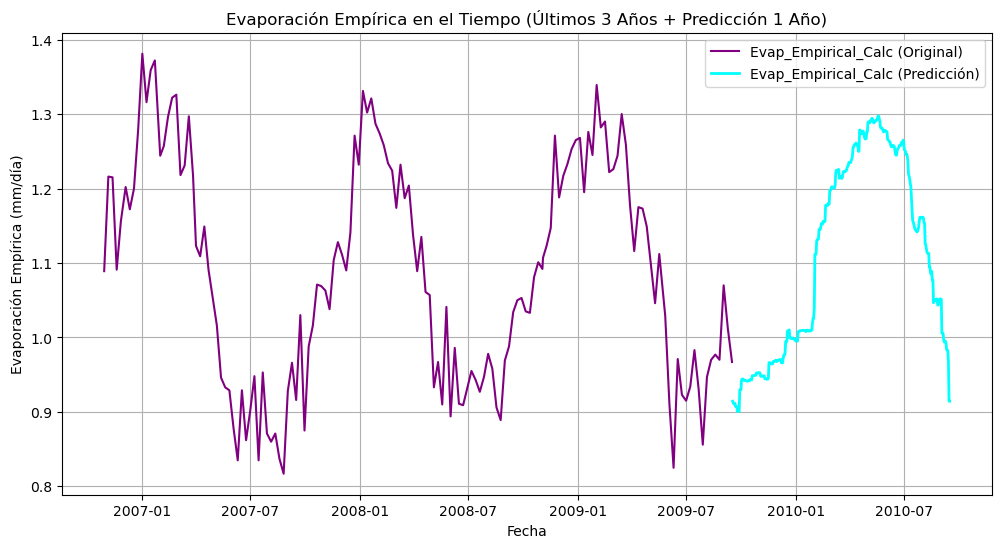

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('03A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'Evap_Empirical_Calc': predictions_rf}, index=future_dates_rf)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Filtrar los últimos 3 años de datos originales
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(last_3_years['FECHA'], last_3_years['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Original)', color='purple')
if forecast_df_rf is not None:
    plt.plot(forecast_df_rf.index, forecast_df_rf['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Predicción)', color='cyan', linewidth=2)

# Configuración del gráfico
plt.title('Evaporación Empírica en el Tiempo (Últimos 3 Años + Predicción 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación Empírica (mm/día)')
plt.legend()
plt.grid()
plt.show()


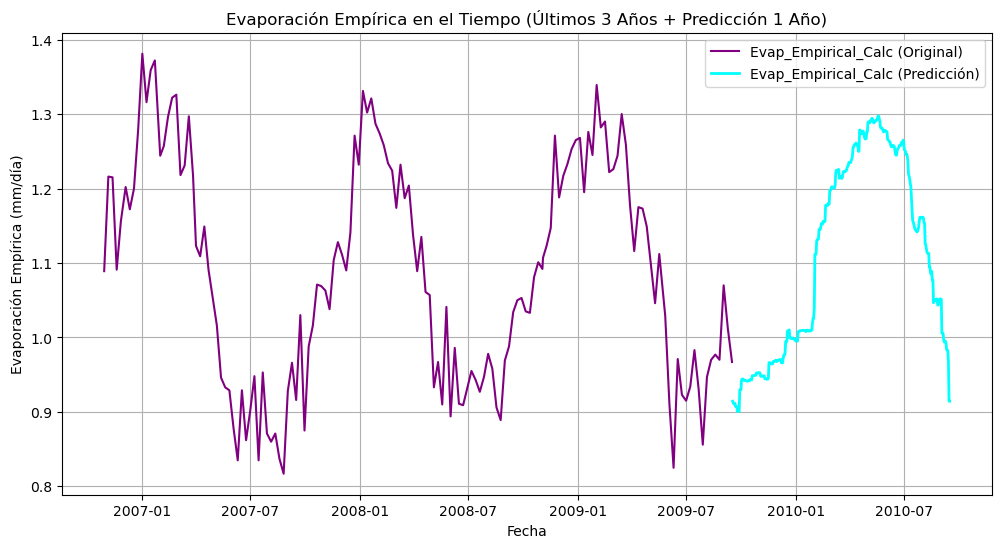

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('02A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'Evap_Empirical_Calc': predictions_rf}, index=future_dates_rf)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Filtrar los últimos 3 años de datos originales
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(last_3_years['FECHA'], last_3_years['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Original)', color='purple')
if forecast_df_rf is not None:
    plt.plot(forecast_df_rf.index, forecast_df_rf['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Predicción)', color='cyan', linewidth=2)

# Configuración del gráfico
plt.title('Evaporación Empírica en el Tiempo (Últimos 3 Años + Predicción 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación Empírica (mm/día)')
plt.legend()
plt.grid()
plt.show()



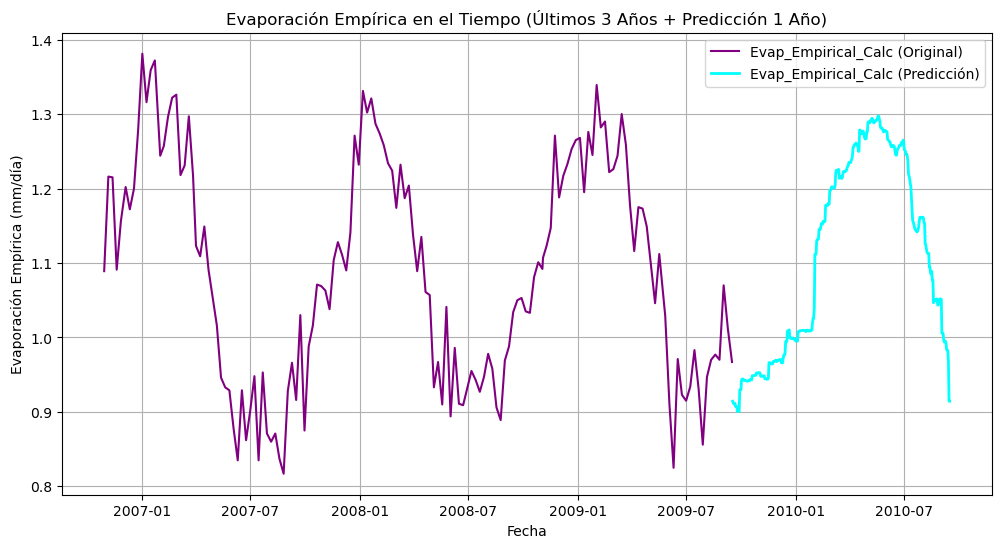

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('05A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'Evap_Empirical_Calc': predictions_rf}, index=future_dates_rf)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Filtrar los últimos 3 años de datos originales
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(last_3_years['FECHA'], last_3_years['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Original)', color='purple')
if forecast_df_rf is not None:
    plt.plot(forecast_df_rf.index, forecast_df_rf['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Predicción)', color='cyan', linewidth=2)

# Configuración del gráfico
plt.title('Evaporación Empírica en el Tiempo (Últimos 3 Años + Predicción 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación Empírica (mm/día)')
plt.legend()
plt.grid()
plt.show()


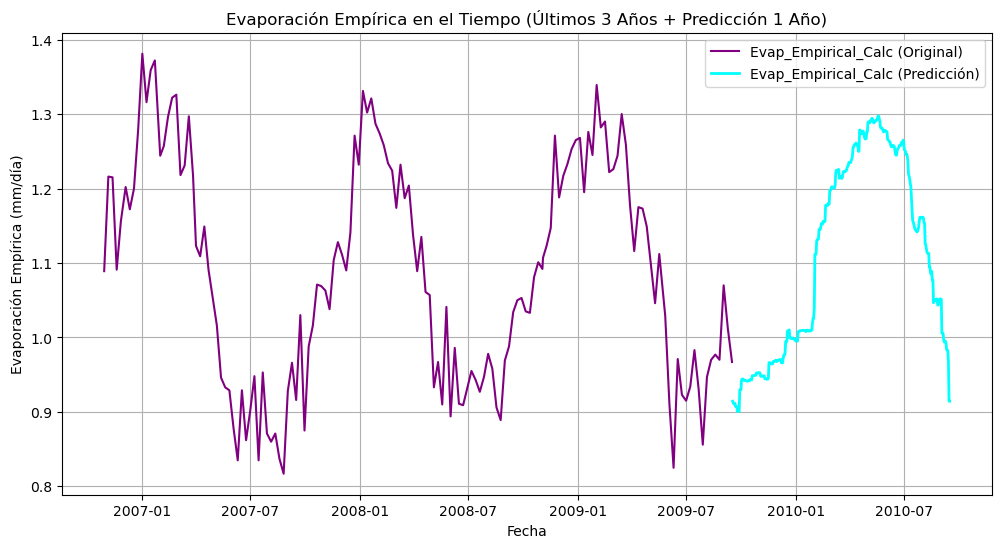

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('06A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'Evap_Empirical_Calc': predictions_rf}, index=future_dates_rf)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Filtrar los últimos 3 años de datos originales
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(last_3_years['FECHA'], last_3_years['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Original)', color='purple')
if forecast_df_rf is not None:
    plt.plot(forecast_df_rf.index, forecast_df_rf['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Predicción)', color='cyan', linewidth=2)

# Configuración del gráfico
plt.title('Evaporación Empírica en el Tiempo (Últimos 3 Años + Predicción 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación Empírica (mm/día)')
plt.legend()
plt.grid()
plt.show()


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Cargar el dataset
data = pd.read_csv('06A_Dataset.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'FECHA': future_dates_rf, 'Evap_Empirical_Calc': predictions_rf})
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Guardar predicciones en un archivo CSV
if forecast_df_rf is not None:
    forecast_df_rf.to_csv('predicciones.csv', index=False)
    print("Predicciones guardadas en 'predicciones.csv'.")
else:
    print("No se pudo generar el archivo de predicciones.")

# Guardar los últimos 3 años de datos originales en un archivo CSV
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]
last_3_years[['FECHA', 'Evap_Empirical_Calc']].to_csv('datos_originales.csv', index=False)
print("Datos originales guardados en 'datos_originales.csv'.")


Predicciones guardadas en 'predicciones.csv'.
Datos originales guardados en 'datos_originales.csv'.


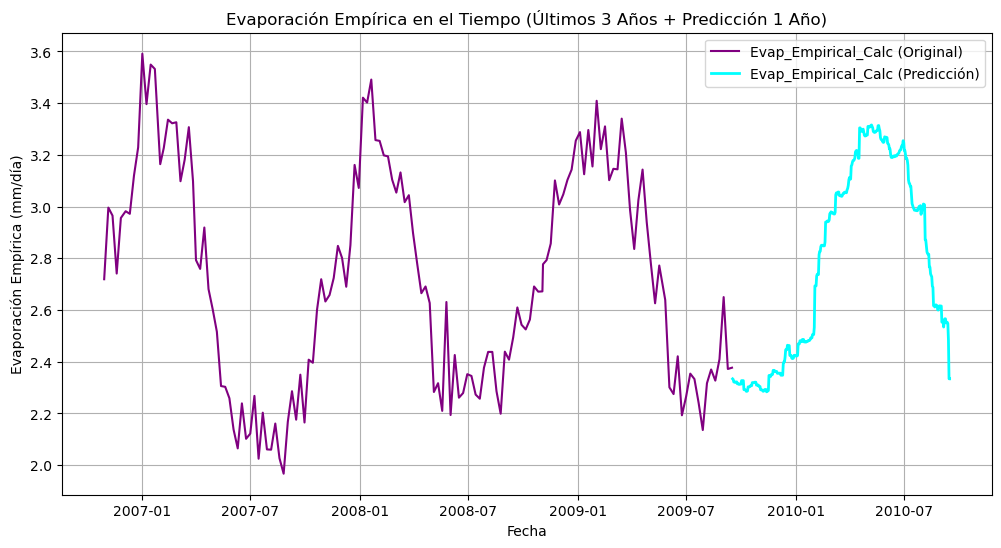

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('dataset_modificadov2.csv', low_memory=False)

# Asegurarse de que la columna FECHA se procese correctamente
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%Y', errors='coerce')  # Cambiado a %d-%m-%Y

# Verificar si hay valores nulos en FECHA
if data['FECHA'].isna().any():
    print("Algunas fechas no se pudieron convertir correctamente. Revisa los datos.")
    print(data[data['FECHA'].isna()])

# Preparar el dataset con la evaporación empírica y fechas
data_subset = data[['FECHA', 'Evap_Empirical_Calc']].dropna()

# Verificar si hay datos después de eliminar nulos
if data_subset.empty:
    raise ValueError("El subconjunto de datos está vacío. Revisa las columnas de evaporación y fechas.")

# Crear variables temporales adicionales
data_subset = data_subset.reset_index()
data_subset['DayOfYear'] = data_subset['FECHA'].dt.dayofyear
data_subset['DaysSinceStart'] = (data_subset['FECHA'] - data_subset['FECHA'].min()).dt.days

# Modelo RandomForest para predecir evaporación empírica
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
X = data_subset[['DayOfYear', 'DaysSinceStart']]
y = data_subset['Evap_Empirical_Calc']
model_rf.fit(X, y)

# Generar predicciones para 1 año
future_days = pd.DataFrame({
    'DayOfYear': [(i % 365) + 1 for i in range(len(data_subset), len(data_subset) + 365)],
    'DaysSinceStart': range(data_subset['DaysSinceStart'].max() + 1, data_subset['DaysSinceStart'].max() + 1 + 365)
})
predictions_rf = model_rf.predict(future_days)

# Crear un DataFrame con las predicciones
try:
    future_dates_rf = pd.date_range(start=data_subset['FECHA'].max(), periods=365 + 1, freq='D')[1:]
    forecast_df_rf = pd.DataFrame({'Evap_Empirical_Calc': predictions_rf}, index=future_dates_rf)
except Exception as e:
    print(f"Error generando las fechas futuras: {e}")
    forecast_df_rf = None

# Filtrar los últimos 3 años de datos originales
last_3_years = data_subset[data_subset['FECHA'] >= (data_subset['FECHA'].max() - pd.DateOffset(years=3))]

# Graficar los últimos 3 años de datos originales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(last_3_years['FECHA'], last_3_years['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Original)', color='purple')
if forecast_df_rf is not None:
    plt.plot(forecast_df_rf.index, forecast_df_rf['Evap_Empirical_Calc'], label='Evap_Empirical_Calc (Predicción)', color='cyan', linewidth=2)

# Configuración del gráfico
plt.title('Evaporación Empírica en el Tiempo (Últimos 3 Años + Predicción 1 Año)')
plt.xlabel('Fecha')
plt.ylabel('Evaporación Empírica (mm/día)')
plt.legend()
plt.grid()
plt.show()
